## Handwritten Digit Classification using NNs

In [14]:
import torch
import torch.nn as nn
import torchvision 
import torch.optim as optim 
from torchvision import transforms, datasets 
import torch.nn.functional as F

In [7]:
## Load the dataset and define hyperparams 
batch_size = 64 
torch.manual_seed(1)
num_epochs = 10 
learning_rate = 0.001 

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [11]:
train_dataset = datasets.MNIST(root='.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='.', train=True, download=True, transform=transform)

In [20]:
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True)

In [32]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(28*28, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.l2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.l3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.l4 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.bn1(self.l1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.l2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.l3(x)))
        x = self.dropout(x)
        x = self.l4(x)
        return x 

In [33]:
device = torch.device('cuda')

In [34]:
model = Net().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [35]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item() / len(labels)

In [36]:
def train(model, device, train_dl, loss_fn, optimizer, num_epochs):
    model.train()
    running_loss, running_acc = 0.0, 0.0
    for i, (inputs, labels) in enumerate(train_dl):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)

        if(i + 1) % 200 == 0:
            print(f'Epoch {num_epochs}, Batch {i+1}, Loss: {running_loss/200:.4f}, Accuracy: {running_acc/200:.4f}')
            running_loss, running_acc = 0.0, 0.0

In [37]:
def test(model, device, test_dl, loss_fn):
    model.eval()
    test_loss, test_acc = 0.0, 0.0
    with torch.no_grad():
        for inputs, labels in test_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()
            test_acc += accuracy(outputs, labels)

    avg_loss, avg_acc = test_loss / len(test_dl), test_acc / len(test_dl)
    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {avg_acc:.4f}')
    scheduler.step(avg_loss)

In [38]:
for epoch in range(1, num_epochs + 1):
    train(model, device, train_dl, loss_fn, optimizer, epoch)
    test(model, device, test_dl, loss_fn)

Epoch 1, Batch 200, Loss: 0.5505, Accuracy: 0.8491
Epoch 1, Batch 400, Loss: 0.2608, Accuracy: 0.9263
Epoch 1, Batch 600, Loss: 0.2286, Accuracy: 0.9327
Epoch 1, Batch 800, Loss: 0.1960, Accuracy: 0.9402
Test Loss: 0.0937, Test Accuracy: 0.9715
Epoch 2, Batch 200, Loss: 0.1677, Accuracy: 0.9512
Epoch 2, Batch 400, Loss: 0.1521, Accuracy: 0.9544
Epoch 2, Batch 600, Loss: 0.1463, Accuracy: 0.9566
Epoch 2, Batch 800, Loss: 0.1518, Accuracy: 0.9551
Test Loss: 0.0612, Test Accuracy: 0.9815
Epoch 3, Batch 200, Loss: 0.1138, Accuracy: 0.9655
Epoch 3, Batch 400, Loss: 0.1287, Accuracy: 0.9592
Epoch 3, Batch 600, Loss: 0.1244, Accuracy: 0.9620
Epoch 3, Batch 800, Loss: 0.1145, Accuracy: 0.9650
Test Loss: 0.0442, Test Accuracy: 0.9864
Epoch 4, Batch 200, Loss: 0.0953, Accuracy: 0.9702
Epoch 4, Batch 400, Loss: 0.1126, Accuracy: 0.9643
Epoch 4, Batch 600, Loss: 0.1008, Accuracy: 0.9697
Epoch 4, Batch 800, Loss: 0.0998, Accuracy: 0.9694
Test Loss: 0.0364, Test Accuracy: 0.9885
Epoch 5, Batch 200, 

In [42]:
import matplotlib.pyplot as plt

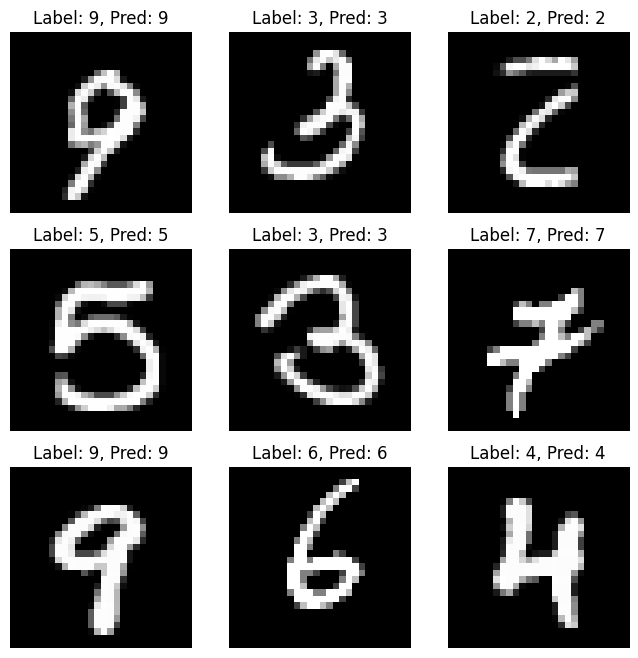

In [44]:
def viz_predictions():
    model.eval()
    samples, labels = next(iter(test_dl))
    samples = samples.to(device)
    outputs = model(samples)
    _, preds = torch.max(outputs, 1)

    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for i, ax in enumerate(axes.ravel()):
        ax.imshow(samples[i].cpu().numpy().squeeze(), cmap = 'gray')
        ax.set_title(f'Label: {labels[i]}, Pred: {preds[i]}')
        ax.axis('off')
    plt.show()

viz_predictions()